In [1]:
from fastai import *
from fastai.vision import *
from fastai.utils.ipython import *
from fastai.callbacks.tracker import SaveModelCallback
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pretrainedmodels

In [2]:
%matplotlib inline

In [3]:
path = Path(".")
data_path = path / ".." / ".." / ".." / "Dataset" / "Sipakmed Dataset" / "wsi_dataset"
data_path.ls()

[PosixPath('../../../Dataset/Sipakmed Dataset/wsi_dataset/train'),
 PosixPath('../../../Dataset/Sipakmed Dataset/wsi_dataset/test')]

In [4]:
data_init = (ImageList.from_folder(data_path / "train")
            .split_none()
            .label_from_folder())
data_init

LabelLists;

Train: LabelList (966 items)
x: ImageList
Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
skf

StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [6]:
tfms = get_transforms(flip_vert=True, max_warp=0.0, max_rotate=60.0, max_zoom=1.0)

In [7]:
def model_callback(model, model_name):
    return [SaveModelCallback(model, every="improvement", monitor="accuracy", name=model_name)]

In [8]:
our_metrics = [accuracy, Precision(average="macro"), Recall(average="macro"), FBeta(average="macro"), KappaScore(weights="quadratic")]
our_metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.Tensor) -> <function NewType.<locals>.new_type at 0x7f3ff0523400>>,
 Precision(average='macro', pos_label=1, eps=1e-09),
 Recall(average='macro', pos_label=1, eps=1e-09),
 FBeta(average='macro', pos_label=1, eps=1e-09, beta=2),
 KappaScore(weights='quadratic')]

In [9]:
idxs = [[train_idx, val_idx] for train_idx, val_idx in skf.split(data_init.x.items, data_init.y.items)]

In [10]:
def get_fold_data(fold_idxs, img_size, bs=16):
    return (ImageList.from_folder(data_path / "train")
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=img_size)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

# Fold-1

In [11]:
fold_data = get_fold_data(idxs[0], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (772 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (194 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

In [12]:
model_name = 'vgg19_bn' # could be fbresnet152 or inceptionresnetv2
model_cadene = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

In [20]:
model_cadene.last_linear =  torch.nn.Linear(model_cadene.last_linear.in_features, int(fold_data.c))
model_cadene.input_size = [3, 224, 224]
model_cadene

VGG(
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [21]:
learner = Learner(fold_data, model_cadene, metrics=our_metrics).to_fp16()
learner

Learner(data=ImageDataBunch;

Train: LabelList (772 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (194 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None, model=VGG(
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, mom

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


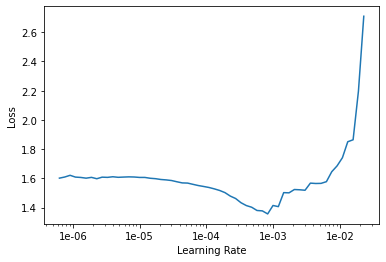

In [22]:
learner.lr_find()
learner.recorder.plot()

In [23]:
learner.fit_one_cycle(30, max_lr=slice(3e-04), callbacks=model_callback(learner, "best-base-vgg19-sipak-multiclass-fold1"))
learner.save("last-base-vgg19-sipak-multiclass-fold1")

Better model found at epoch 0 with accuracy value: 0.7422680258750916.
Better model found at epoch 1 with accuracy value: 0.9432989954948425.
Better model found at epoch 12 with accuracy value: 0.9639175534248352.
Better model found at epoch 20 with accuracy value: 0.969072163105011.
Better model found at epoch 21 with accuracy value: 0.9793814420700073.


# Fold-2

In [24]:
fold_data = get_fold_data(idxs[1], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (773 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (193 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


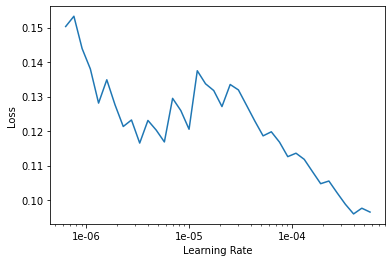

In [26]:
learner.load("best-base-vgg19-sipak-multiclass-fold1")
learner = to_fp16(learner)
learner.data = fold_data
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [27]:
learner.fit_one_cycle(30, max_lr=slice(3e-04), callbacks=model_callback(learner, "best-base-vgg19-sipak-multiclass-fold2"))
learner.save("last-base-vgg19-sipak-multiclass-fold2")

Better model found at epoch 0 with accuracy value: 0.984455943107605.


# Fold-3

In [28]:
fold_data = get_fold_data(idxs[2], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (773 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (193 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


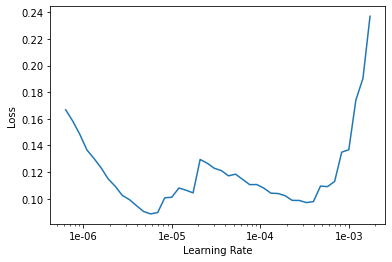

In [31]:
learner.load("best-base-vgg19-sipak-multiclass-fold2")
learner = to_fp16(learner)
learner.data = fold_data
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [32]:
learner.fit_one_cycle(30, max_lr=slice(3e-06), callbacks=model_callback(learner, "best-base-vgg19-sipak-multiclass-fold3"))
learner.save("last-base-vgg19-sipak-multiclass-fold3")

Better model found at epoch 0 with accuracy value: 0.9792746305465698.
Better model found at epoch 11 with accuracy value: 0.984455943107605.


# Fold-4

In [33]:
fold_data = get_fold_data(idxs[3], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (773 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (193 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


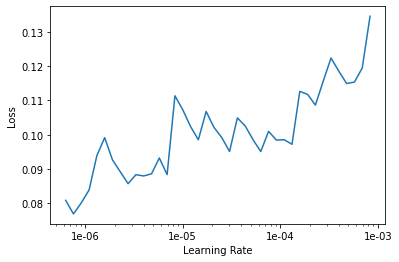

In [34]:
learner.load("best-base-vgg19-sipak-multiclass-fold3")
learner = to_fp16(learner)
learner.data = fold_data
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [35]:
learner.fit_one_cycle(30, max_lr=slice(6.5e-07), callbacks=model_callback(learner, "best-base-vgg19-sipak-multiclass-fold4"))
learner.save("last-base-vgg19-sipak-multiclass-fold4")

Better model found at epoch 0 with accuracy value: 0.9948186278343201.


KeyboardInterrupt: 

# Fold-5

In [36]:
fold_data = get_fold_data(idxs[4], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (773 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (193 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


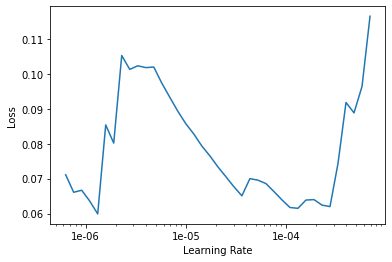

In [37]:
learner.load("best-base-vgg19-sipak-multiclass-fold4")
learner = to_fp16(learner)
learner.data = fold_data
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [38]:
learner.fit_one_cycle(30, max_lr=slice(1e-06), callbacks=model_callback(learner, "best-base-vgg19-sipak-multiclass-fold5"))
learner.save("last-base-vgg19-sipak-multiclass-fold5")

Better model found at epoch 0 with accuracy value: 1.0.


# Testing on 30 images (in valid folder)

In [39]:
learner.load("last-base-vgg19-sipak-multiclass-fold5")

Learner(data=ImageDataBunch;

Train: LabelList (773 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (193 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None, model=VGG(
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, mom

In [40]:
all_data = (ImageList.from_folder(data_path)
            .split_by_folder(train="train", valid="test")
            .label_from_folder()
            .transform(None, size=224)
            .databunch(bs=1)
            .normalize(imagenet_stats))
all_data

ImageDataBunch;

Train: LabelList (966 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset;

Valid: LabelList (29 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset;

Test: None

In [41]:
imgs, labels = all_data.valid_ds.x, all_data.valid_ds.y
binary_classes = ["Abnormal", "Benign", "Normal"]

In [42]:
def get_label(label):
    if "abnormal" in label:
        return "Abnormal"
    elif "normal" in label:
        return "Normal"
    elif "benign" in label:
        return "Benign"

y_preds, y_true = [], []
for img, label in zip(imgs, labels):
    y_true.append(get_label(str(label)))
    y_preds.append(get_label(str(learner.predict(img)[0])))

In [43]:
multi_y_preds, multi_y_true = [], []
for img, label in zip(imgs, labels):
    multi_y_true.append(str(label))
    multi_y_preds.append(str(learner.predict(img)[0]))

In [44]:
multi_classes = all_data.classes
multi_classes

['abnormal_Dyskeratotic',
 'abnormal_Koilocytotic',
 'benign_Metaplastic',
 'normal_Parabasal',
 'normal_Superficial-Intermediate']

In [45]:
from sklearn.metrics import confusion_matrix

np.set_printoptions(precision=2)

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax

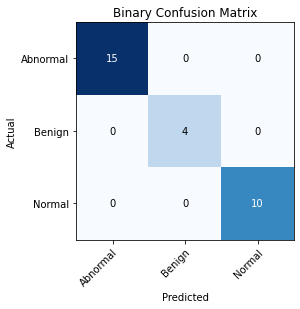

In [46]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_preds, classes=binary_classes, title='Binary Confusion Matrix')
plt.show()

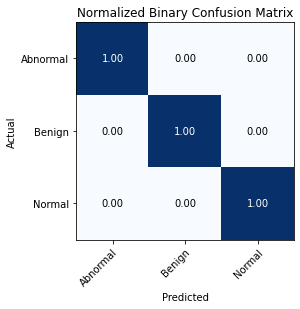

In [47]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_preds, normalize=True, classes=binary_classes, 
                      title='Normalized Binary Confusion Matrix')
plt.show()

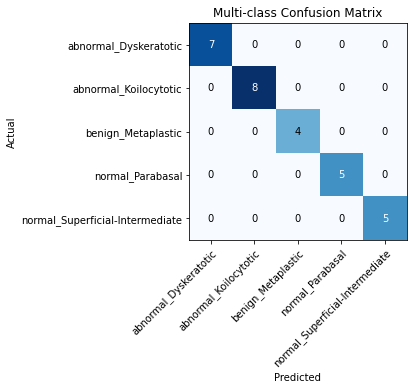

In [48]:
# Plot normalized confusion matrix
plot_confusion_matrix(multi_y_true, multi_y_preds, normalize=False, classes=multi_classes, 
                      title='Multi-class Confusion Matrix')
plt.show()

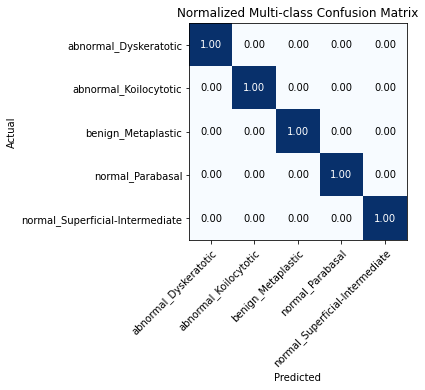

In [49]:
# Plot normalized confusion matrix
plot_confusion_matrix(multi_y_true, multi_y_preds, normalize=True, classes=multi_classes, 
                      title='Normalized Multi-class Confusion Matrix')
plt.show()

# Results (first save results.csv)

In [50]:
def compute_results(fname):
    df = pd.read_csv(fname)
    print(df)
    print("*-*" * 10)
    print("Results :-")
    mean_df = np.mean(df, axis=0)
    mean_error_df = np.mean(np.abs(mean_df - df), axis=0)
    for col, mean, error in zip(list(df.columns), list(mean_df.values), list(mean_error_df.values)):
        print(f"{col.capitalize()} : {mean * 100:.4f} % | { error * 100:.4f} %")

compute_results("results.csv")

   accuracy  precision    recall    f_beta  kappa_score
0  0.979381   0.983409  0.979353  0.980105     0.981812
1  0.984456   0.987615  0.988426  0.988237     0.990801
2  0.984456   0.988602  0.988030  0.988121     0.995355
3  0.994819   0.995652  0.996296  0.996141     0.993885
4  1.000000   1.000000  1.000000  1.000000     1.000000
*-**-**-**-**-**-**-**-**-**-*
Results :-
Accuracy : 98.8622 % | 0.7030 %
Precision : 99.1056 % | 0.5416 %
Recall : 99.0421 % | 0.6182 %
F_beta : 99.0521 % | 0.6040 %
Kappa_score : 99.2371 % | 0.4851 %


# Exporting model

In [51]:
learner.export("best-base-vgg19-sipak-multiclass.pkl")